In [13]:
import sys
sys.path.append('../')

from helpers import helper
from dataloaders import dataloader
from networks import Unet
import config

import cv2
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

device = config.get_device()
trainset, train_dl = dataloader.getData('../../datasets/experiment.csv', batch_size=4)


Using device: mps


In [14]:
network = Unet.getModel()

Load model from ../models/unet_default.pth


torch.Size([4, 3, 256, 256])
torch.Size([4, 2, 256, 256])
loss: 1096.8663330078125


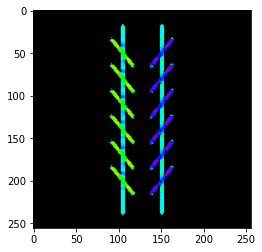

In [18]:
def test(decoder, test_dl):
    decoder.to(device)
    for images, labels in train_dl:
        images = images.to(device)
        labels = labels.to(device)
        print(images.shape)
        outputs = decoder(images)

        helper.plot_tensor_output(outputs[0])

        helper
        print(outputs.shape)
        break

    loss = nn.MSELoss(reduction='sum')(outputs, labels)
    loss.backward()
    print(f'loss: {loss.item()}')
    
test(network, train_dl)

In [8]:
def train(trainloader, model, criterion, optimizer, scaler, device):
    # train_acc = 0.0
    train_loss = 0.0
    model.train()
    for images, labels in tqdm(trainloader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=True):
            output = model(images)
            loss = criterion(output, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # acc = ((output.argmax(dim=1) == labels).float().mean())
        # train_acc += acc
        train_loss += loss
        del output
        del loss
        
    # Decay LR by a factor of 0.1 every 2 epochs
    # exp_lr_scheduler.step()
    model.save()
    return train_loss/len(trainloader)

train_loss = train(train_dl, network, nn.MSELoss(reduction='sum'), torch.optim.Adam(network.parameters(), lr=0.001), torch.cuda.amp.GradScaler(), device)

/Users/terry/miniconda3/envs/torch-nightly/lib/python3.8/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
  0%|          | 0/250 [00:00<?, ?it/s]/Users/terry/miniconda3/envs/torch-nightly/lib/python3.8/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|██████████| 250/250 [02:11<00:00,  1.90it/s]


In [9]:
train_loss

tensor(3845.3284, device='mps:0', grad_fn=<DivBackward0>)

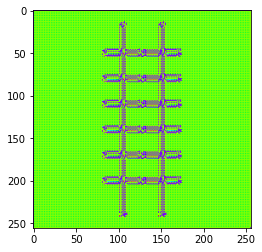

In [12]:
image_path = "../../datasets/experiment/images/img_1_3.png"

def test_image(network, image_path):
    network.to(device)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype('float32')

    # turn image to tensor with correct shape
    image = torch.tensor(image).permute(2, 0, 1).unsqueeze(0)
    image = image.to(device)
    
    output = network(image)
    helper.plot_tensor_output(output[0])

test_image(network, image_path)
